### Import modules

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw

In [2]:
mini_G = nx.read_gml('./Graphs/mini_graph.gml')
vocab_G = nx.read_gml('./Graphs/corpus_vocab.gml')
len(vocab_G)

11578

### Degree distribution

In [3]:
def degree_distro(degrees: np.array, name) -> float:
    """Get the degree exponent and plot the degree distribution of a network
    Parameters:
        degrees (np.array): the degrees of the network
        name (str): degree type
    Returns:
        float: the degree exponent"""
    
    k_min, k_max = min(degrees), max(degrees)
    
    # get log bins and density
    bin_edges = np.logspace(np.log10(k_min), np.log10(k_max), num = 25)
    density, _ = np.histogram(degrees, bins = bin_edges, density = True)
    
    # calculate degree exponent
    res = powerlaw.Fit(degrees, discrete = True)
    print('Gamma:', res.power_law.alpha)
    
    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[: -1] + log_be[1 :]) / 2)
    
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.loglog(x, density, marker = 'o', ls = 'none', color = '#552583')
    plt.title('{}-degree Distribution'.format(name))
    plt.xlabel('Degree k')
    plt.ylabel('Density p(k)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    plt.close()
    
    return res.power_law.alpha

Calculating best minimal value for power law fit
Gamma: 2.116580172099942


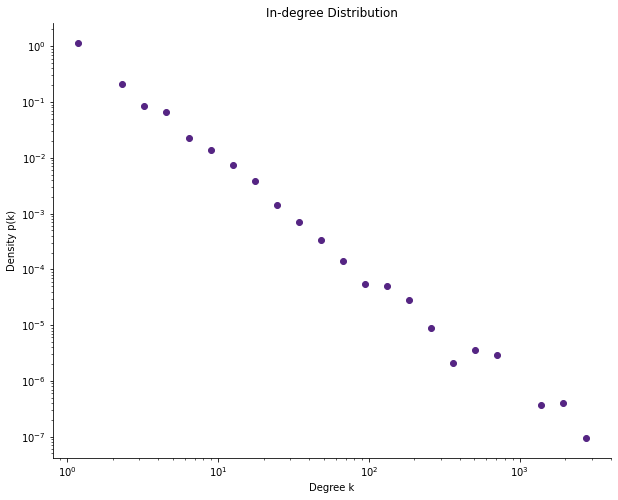

In [4]:
in_deg_exp = degree_distro(np.array([i for i in dict(vocab_G.in_degree()).values() if i > 0]), 'In')

Calculating best minimal value for power law fit
Gamma: 2.196581597356233


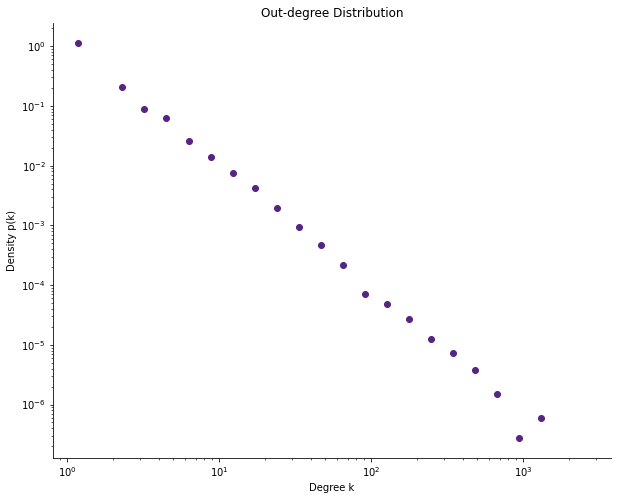

In [5]:
out_deg_exp = degree_distro(np.array([i for i in dict(vocab_G.out_degree()).values() if i > 0]), 'Out')